# Simple Turbulence Tests

## Imports

In [1]:
# IMPORTANT: check gpustat --watch before 
# running scripts on the cluster
# BETTER NOT USE NOTEBOOKS AT ALL,
# THEY BLOCK THE GPU MEMORY IF NOT
# RESET PROPERLY
import os
# set the correct GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
# you may also use
# # ==== GPU selection ====
# from autocvd import autocvd
# autocvd(num_gpus = 1)
# # =======================
# in regular python scripts

# numerics
import jax
import jax.numpy as jnp

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# jf1uids data structures
from jf1uids import SimulationConfig
from jf1uids import SimulationParams
from jf1uids.option_classes import WindConfig
from jf1uids.option_classes.simulation_config import BACKWARDS, OSHER, FORWARDS

# jf1uids setup functions
from jf1uids import get_helper_data
from jf1uids.fluid_equations.fluid import construct_primitive_state
from jf1uids import get_registered_variables
from jf1uids.option_classes.simulation_config import finalize_config

# turbulent ic setup
from jf1uids.initial_condition_generation.turb import create_turb_field

# main simulation function
from jf1uids import time_integration

# units
from jf1uids import CodeUnits
from astropy import units as u
import astropy.constants as c

## Initiating the stellar wind simulation

In [2]:
print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
box_size = 1.0

# resolution
num_cells = 128

# turbulence
turbulence = True
wanted_rms = 50 * u.km / u.s

fixed_timestep = False
dt_max = 0.1

# setup simulation config
config = SimulationConfig(
    runtime_debugging = False,
    first_order_fallback = False,
    progress_bar = True,
    dimensionality = 3,
    num_ghost_cells = 2,
    box_size = box_size, 
    num_cells = num_cells,
    fixed_timestep = fixed_timestep,
    differentiation_mode = FORWARDS,
    return_snapshots = True,
    num_snapshots = 80,
)

helper_data = get_helper_data(config)
registered_variables = get_registered_variables(config)

👷 Setting up simulation...


## Setting the simulation parameters and initial state

In [3]:
# setup the unit system
code_length = 3 * u.parsec
code_mass = 1 * u.M_sun
code_velocity = 100 * u.km / u.s
code_units = CodeUnits(code_length, code_mass, code_velocity)

# time domain
C_CFL = 0.4

# set the final time of the simulation
t_final = 1.0 * 1e4 * u.yr
t_end = t_final.to(code_units.code_time).value

# set the simulation parameters
params = SimulationParams(
    C_cfl = C_CFL,
    dt_max = dt_max,
    gamma = gamma,
    t_end = t_end,
)

# homogeneous initial state
rho_0 = 2 * c.m_p / u.cm**3
p_0 = 3e4 * u.K / u.cm**3 * c.k_B

rho = jnp.ones((config.num_cells, config.num_cells, config.num_cells)) * rho_0.to(code_units.code_density).value

# turbulence parameters
turbulence_slope = -2
kmin = 2
kmax = 64

# turbulence setup
u_x = create_turb_field(config.num_cells, 1, turbulence_slope, kmin, kmax, seed = 1)
u_y = create_turb_field(config.num_cells, 1, turbulence_slope, kmin, kmax, seed = 2)
u_z = create_turb_field(config.num_cells, 1, turbulence_slope, kmin, kmax, seed = 3)

a = num_cells // 2 - 10
b = num_cells // 2 + 10

# scale the turbulence to the desired rms velocity
rms_vel = jnp.sqrt(jnp.mean(u_x**2 + u_y**2 + u_z**2))
u_x = u_x / rms_vel * wanted_rms.to(code_units.code_velocity).value
u_y = u_y / rms_vel * wanted_rms.to(code_units.code_velocity).value
u_z = u_z / rms_vel * wanted_rms.to(code_units.code_velocity).value

p = jnp.ones((config.num_cells, config.num_cells, config.num_cells)) * p_0.to(code_units.code_pressure).value

# construct primitive state
initial_state = construct_primitive_state(
    config = config,
    registered_variables=registered_variables,
    density = rho,
    velocity_x = u_x,
    velocity_y = u_y,
    velocity_z = u_z,
    gas_pressure = p
)

config = finalize_config(config, initial_state.shape)

Automatically setting open boundaries for Cartesian geometry.


## Simulation and Gradient

In [4]:
result = time_integration(initial_state, config, params, helper_data, registered_variables)
final_state = result.states[-1]

 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 100.0% 


## Visualization

### Cut through the Simulation

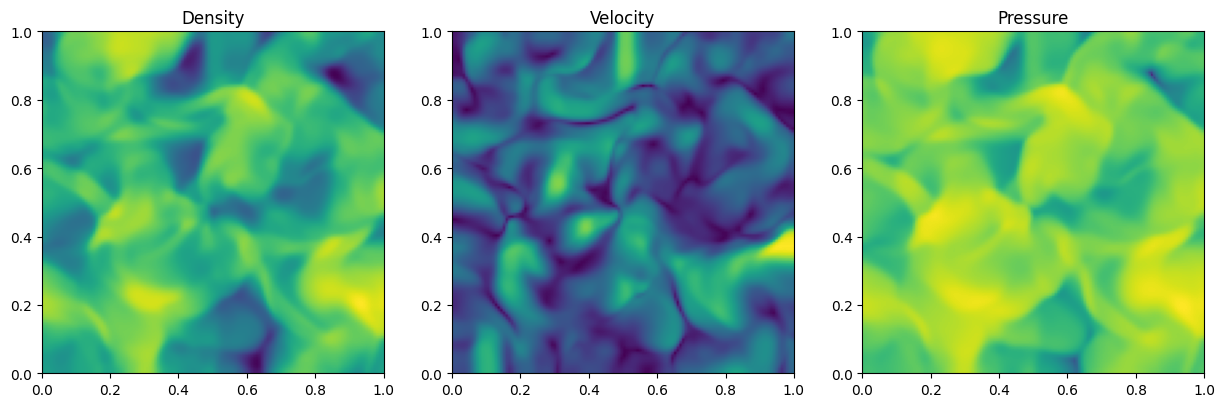

In [5]:
from matplotlib.colors import LogNorm

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# plot cuts at this z level
z_level = num_cells // 2

ax1.imshow(final_state[0, :, :, z_level].T, origin = "lower", extent = [0, 1, 0, 1], norm = LogNorm())
ax1.set_title("Density")

ax2.imshow(jnp.sqrt(final_state[1, :, :, z_level]**2 + final_state[2, :, :, z_level]**2).T, origin = "lower", extent = [0, 1, 0, 1])
ax2.set_title("Velocity")

ax3.imshow(final_state[4, :, :, z_level].T, origin = "lower", extent = [0, 1, 0, 1], norm = LogNorm())
ax3.set_title("Pressure")

# equal aspect ratio
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')
ax3.set_aspect('equal', 'box')